# MATH50003 Numerical Analysis: Problem 3

This problem sheet explores implementation of triangular solves,
supporting a matrix with two super-diagonals, as well as
permutation and Householder reflections that can be applied to a vector in
$O(n)$ complexity.

In [1]:
using LinearAlgebra, Test

# We will override these functions below
import Base: getindex, setindex!, size, *, \

## 1. Dense Matrices

**Problem 1.1** Show that `A*x` is not
implemented as `mul(A, x)` from the lecture notes
by finding a `Float64` example  where the bits do not match.

**SOLUTION**

First we have to define `mul(A, x)` as in the lecture notes:

In [2]:
function mul(A, x)
    m,n = size(A)
    c = zeros(eltype(x), m) # eltype is the type of the elements of a vector/matrix
    for j = 1:n, k = 1:m
        c[k] += A[k, j] * x[j]
    end
    c
end

mul (generic function with 1 method)

Then we can easily find examples, in fact we can write a function that searches for examples:

In [3]:
using ColorBitstring

function findblasmuldifference(n,l)
	for j = 1:n
		A = randn(l,l)
		x = rand(l)
		if A*x != mul(A,x) 
			return (A,x)
		end
	end
end

n = 100 # number of attempts
l = 10 # size of objects
(A,x) = findblasmuldifference(n,l) # find a difference

println("Bits of obtained A*x")
printlnbits.(A*x);
println("Bits of obtained mul(A,x)")
printlnbits.(mul(A,x));
println("Difference vector between the two solutions:")
println(A*x-mul(A,x))

Bits of obtained A*x
0011111111111110110100100101000101011010011111010000111110001110
1011111111100111011111111010101101010011111011011010110110100110
0011111111100011100000101101011111101111101111011001100010001110
0011111111111111101101000101100110000000000111010000111100111011
1011111110110111111110010110010001100000101100110110111001110000
0011111111101001001010001001111111100101011100100011100000100100
1011111111111110011110011110100011000010010100000100110011000000
0100000000000011101001110110101000111011110101110110001011111100
1011111111100110100010010001111010000100010011010001101001010010
1011111111111001001011101010100011110101110011000000110110000001
Bits of obtained mul(A,x)
0011111111111110110100100101000101011010011111010000111110001110
1011111111100111011111111010101101010011111011011010110110100110
0011111111100011100000101101011111101111101111011001100010001000
0011111111111111101101000101100110000000000111010000111100111010
1011111110110111111110010110010001100000101

## 2. Triangular Matrices

**Problem 2.1** Complete the following functions for solving linear systems with
triangular systems by implementing back and forward-substitution:

In [4]:
function ldiv(U::UpperTriangular, b)
    n = size(U,1)
    
    if length(b) != n
        error("The system is not compatible")
    end
        
    x = zeros(n)  # the solution vector
    ## TODO: populate x using back-substitution
end

function ldiv(U::LowerTriangular, b)
    n = size(U,1)
    
    if length(b) != n
        error("The system is not compatible")
    end
        
    x = zeros(n)  # the solution vector
    ## TODO: populate x using forward-substitution
end

ldiv (generic function with 2 methods)

**SOLUTION**

In [5]:
function ldiv(U::UpperTriangular, b)
    n = size(U,1)
    
    if length(b) != n
        error("The system is not compatible")
    end
        
    x = zeros(n)  # the solution vector
    
    for k = n:-1:1  # start with k=n, then k=n-1, ...
        r = b[k]  # dummy variable
        for j = k+1:n
            r -= U[k,j]*x[j] # equivalent to r = r-U[k,j]*x[j]
        end
        x[k] = r/U[k,k]
    end
    x
end

function ldiv(U::LowerTriangular, b)
    n = size(U,1)
    
    if length(b) != n
        error("The system is not compatible")
    end
        
    x = zeros(n)  # the solution vector

    for k = 1:n  # start with k=1
        r = b[k]  # dummy variable
        for j = 1:k-1
            r -= U[k,j]*x[j]
        end
        x[k] = r/U[k,k]
    end
    x
end

ldiv (generic function with 2 methods)

Here is an example:

In [6]:
x = [1,2,3,4]
Ldense = [1 0 0 0; 2 3 0 0; 4 5 6 0; 7 8 9 10]
Ltriang = LowerTriangular(Ldense)

4×4 LowerTriangular{Int64, Matrix{Int64}}:
 1  ⋅  ⋅   ⋅
 2  3  ⋅   ⋅
 4  5  6   ⋅
 7  8  9  10

In [7]:
Ldense\x-ldiv(Ltriang,x)

4-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0

**Problem 2.2⋆** Given $𝐱 \in \mathbb{R}^n$, find a lower triangular matrix of the form
$$
L = I - 2 𝐯 𝐞_1^⊤
$$
such that:
$$
L 𝐱 = x_1 𝐞_1.
$$
What does $L𝐲$ equal if $𝐲  ∈ ℝ^n$ satisfies $y_1 = 𝐞_1^⊤ 𝐲 = 0$?

**SOLUTION**

By straightforward computation we find

$$Lx = x - 2 𝐯 𝐞_1^⊤x = x - 2 𝐯 x_1$$

and thus we find such a lower triangular $L$ by choosing $v_1 = 0$ and $v_k = \frac{x_k}{2 x_1}$ for $k=2..n$ and $x_1 \neq 0$.

## 3. Banded matrices

**Problem 3.1** Complete the implementation of `UpperTridiagonal` which represents a banded matrix with
bandwidths $(l,u) = (0,2)$:

In [8]:
struct UpperTridiagonal{T} <: AbstractMatrix{T}
    d::Vector{T}   # diagonal entries
    du::Vector{T}  # super-diagonal enries
    du2::Vector{T} # second-super-diagonal entries
end

size(U::UpperTridiagonal) = (length(U.d),length(U.d))

function getindex(U::UpperTridiagonal, k::Int, j::Int)
    d,du,du2 = U.d,U.du,U.du2
    # TODO: return U[k,j]
end

function setindex!(U::UpperTridiagonal, v, k::Int, j::Int)
    d,du,du2 = U.d,U.du,U.du2
    if j > k+2
        error("Cannot modify off-band")
    end

    # TODO: modify d,du,du2 so that U[k,j] == v

    U # by convention we return the matrix
end

setindex! (generic function with 90 methods)

**SOLUTION**

In [9]:
struct UpperTridiagonal{T} <: AbstractMatrix{T}
    d::Vector{T}   # diagonal entries
    du::Vector{T}  # super-diagonal enries
    du2::Vector{T} # second-super-diagonal entries
end

size(U::UpperTridiagonal) = (length(U.d),length(U.d))

function getindex(U::UpperTridiagonal, k::Int, j::Int)
    d,du,du2 = U.d,U.du,U.du2

    if j == k+2
    	return U.du2[k]    
    elseif j == k+1
    	return U.du[k]
    elseif j == k
    	return U.d[k]
    else # off band entries are zero
    	return zero(eltype(U))
    end
end

function setindex!(U::UpperTridiagonal, v, k::Int, j::Int)
    d,du,du2 = U.d,U.du,U.du2
    if (j > k+2)||(j<k)
        error("Cannot modify off-band")
    end

    if j == k+2
    	U.du2[k] = v  
    elseif j == k+1
    	U.du[k] = v
    elseif j == k
    	U.d[k] = v
    end

    U # by convention we return the matrix
end

setindex! (generic function with 90 methods)

We can check that the above methods to read and write entries work:

In [10]:
A = UpperTridiagonal([1,2,3,4], [1,2,3], [1,2])

4×4 UpperTridiagonal{Int64}:
 1  1  1  0
 0  2  2  2
 0  0  3  3
 0  0  0  4

In [11]:
A[1,1] = 2
A

4×4 UpperTridiagonal{Int64}:
 2  1  1  0
 0  2  2  2
 0  0  3  3
 0  0  0  4

**Problem 3.2** Complete the following implementations of `*` and `\` for `UpperTridiagonal` so that
they take only $O(n)$ operations.

In [12]:
function *(U::UpperTridiagonal, x::AbstractVector)
    T = promote_type(eltype(U), eltype(x)) # make a type that contains both the element type of U and x
    b = zeros(T, size(U,1)) # returned vector
    # TODO: populate b so that U*x == b (up to rounding)
end

function \(U::UpperTridiagonal, b::AbstractVector)
    T = promote_type(eltype(U), eltype(b)) # make a type that contains both the element type of U and b
    x = zeros(T, size(U,2)) # returned vector
    # TODO: populate x so that U*x == b (up to rounding)
end

\ (generic function with 136 methods)

**SOLUTION**

In [13]:
function *(U::UpperTridiagonal, x::AbstractVector)
    T = promote_type(eltype(U), eltype(x)) # make a type that contains both the element type of U and x
    b = zeros(T, size(U,1)) # returned vector
    n = size(U)[1]
    for k = 1:n-2
    	b[k] = dot(U[k,k:k+2],x[k:k+2])
    end
    # the last two rows need a bit more care
    b[n-1] = dot(U[n-1,n-1:n],x[n-1:n])
    b[n] = U[n,n]*x[n]
    return b
end

function \(U::UpperTridiagonal, b::AbstractVector)
    T = promote_type(eltype(U), eltype(b)) # make a type that contains both the element type of U and b
    x = zeros(T, size(U,2)) # returned vector
    n = size(U)[1]
    
    if length(b) != n
        error("The system is not compatible")
    end
    
    for k = n:-1:1  # start with k=n, then k=n-1, ...
        r = b[k]  # dummy variable
        for j = k+1:min(k+3,n)
            r -= U[k,j]*x[j]
        end
        x[k] = r/U[k,k]
    end
    x
end

\ (generic function with 136 methods)

And here is an example of what we have implemented in action:

In [14]:
Abanded = UpperTridiagonal([1.1,2.2,3.3,4.4], [1.9,2.8,3.7], [1.5,2.4])
Adense = Matrix(Abanded) # one of many easy ways to convert to dense storage

Adense == Abanded

true

In [15]:
x = [5.2,3/4,2/3,9.1415]
Adense*x

4-element Vector{Float64}:
  8.145
 25.456266666666668
 36.02355000000001
 40.22260000000001

In [16]:
Abanded*x

4-element Vector{Float64}:
  8.145
 25.456266666666668
 36.02355000000001
 40.22260000000001

In [17]:
Adense\x

4-element Vector{Float64}:
  6.277487146066222
  0.7820538024876866
 -2.1274253902662994
  2.0776136363636364

In [18]:
Abanded\x

4-element Vector{Float64}:
  6.277487146066222
  0.7820538024876866
 -2.1274253902662994
  2.0776136363636364

And just for fun, let's do a larger scale dense speed comparison

In [19]:
using BenchmarkTools
n = 10000
Abanded = UpperTridiagonal(rand(n),rand(n-1),rand(n-2))
Adense = Matrix(Abanded) # one of many easy ways to convert to dense storage
x = rand(n)

@btime Adense*x;

  28.055 ms (2 allocations: 78.17 KiB)


In [20]:
@btime Abanded*x;

  833.644 μs (20000 allocations: 1.60 MiB)


In [21]:
@btime Adense\x;

  75.101 ms (2 allocations: 78.17 KiB)


In [22]:
@btime Abanded\x;

  86.562 μs (2 allocations: 78.17 KiB)


## 4. Permutations

**Problem 4.1⋆** What are the permutation matrices corresponding to the following permutations?
$$
\begin{pmatrix}
1 & 2 & 3 \\
3 & 2 & 1
\end{pmatrix}, \begin{pmatrix}
1 & 2 & 3 & 4 & 5 & 6\\
2 & 1 & 4 & 3 & 6 & 5
\end{pmatrix}.
$$

**SOLUTION**

Let $\sigma=\begin{pmatrix}1 & 2 & 3 \\ 3 & 2 & 1\end{pmatrix}$ and $\tau=\begin{pmatrix}1 & 2 & 3 & 4 & 5 & 6\\ 2 & 1 & 4 & 3 & 6 & 5\end{pmatrix}$. There are two ways to construct $P_\sigma$ and $P_\tau$.

- Column by column:
  $$P_\sigma=
  \left(\mathbf{e}_{\sigma_1^{-1}}\middle|\mathbf{e}_{\sigma_2^{-1}}\middle|\mathbf{e}_{\sigma_3^{-1}}\right)=
  \left(\mathbf{e}_3\middle|\mathbf{e}_2\middle|\mathbf{e}_1\right)$$
  $$P_\tau=
  \left(\mathbf{e}_{\tau_1^{-1}}\middle|\mathbf{e}_{\tau_2^{-1}}\middle|\mathbf{e}_{\tau_3^{-1}}\middle|\mathbf{e}_{\tau_4^{-1}}\middle|\mathbf{e}_{\tau_5^{-1}}\middle|\mathbf{e}_{\tau_6^{-1}}\right)=
  \left(\mathbf{e}_2\middle|\mathbf{e}_1\middle|\mathbf{e}_4\middle|\mathbf{e}_3\middle|\mathbf{e}_6\middle|\mathbf{e}_5\right)$$
- Row by row:
  $$P_\sigma=I[\mathbf{\sigma},:]=
  \begin{pmatrix}
  I[\sigma_1,:]\\
  I[\sigma_2,:]\\
  I[\sigma_3,:]
  \end{pmatrix}=
  \begin{pmatrix}
  I[3,:]\\
  I[2,:]\\
  I[1,:]
  \end{pmatrix}$$
  $$P_\tau=I[\mathbf{\tau},:]=
  \begin{pmatrix}
  I[\tau_1,:]\\
  I[\tau_2,:]\\
  I[\tau_3,:]\\
  I[\tau_4,:]\\
  I[\tau_5,:]\\
  I[\tau_6,:]\\
  \end{pmatrix}=
  \begin{pmatrix}
  I[2,:]\\
  I[1,:]\\
  I[4,:]\\
  I[3,:]\\
  I[6,:]\\
  I[5,:]\\
  \end{pmatrix}$$

Either way, we have
$$P_\sigma=
\begin{pmatrix}
0 & 0 & 1\\ 
0 & 1 & 0\\ 
1 & 0 & 0
\end{pmatrix}
\qquad\text{and}\qquad
P_\tau=
\begin{pmatrix}
0 & 1 & 0 & 0 & 0 & 0 \\
1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 1 & 0
\end{pmatrix}$$

**Problem 4.2** Complete the implementation of a type representing
permutation matrices that supports `P[k,j]` and such that `*` takes $O(n)$ operations.

In [23]:
using LinearAlgebra, Test

struct PermutationMatrix <: AbstractMatrix{Int}
    p::Vector{Int} # represents the permutation whose action is v[p]
    function PermutationMatrix(p::Vector)
        sort(p) == 1:length(p) || error("input is not a valid permutation")
        new(p)
    end
end

function size(P::PermutationMatrix)
    (length(P.p),length(P.p))
end
function getindex(P::PermutationMatrix, k::Int, j::Int)
    # P.p[k] == j ? 1 : 0 
    if P.p[k] == j
        1
    else 
        0
    end
end
function *(P::PermutationMatrix, x::AbstractVector)
    x[P.p]
end

# If your code is correct, this "unit test" will succeed
p = [1, 4, 2, 5, 3]
P = PermutationMatrix(p)
@test P == I(5)[p,:]

Test Passed
  Expression: P == (I(5))[p, :]
   Evaluated: [1 0 … 0 0; 0 0 … 1 0; … ; 0 0 … 0 1; 0 0 … 0 0] == sparse([1, 3, 5, 2, 4], [1, 2, 3, 4, 5], Bool[1, 1, 1, 1, 1], 5, 5)

The following codes show that `*` takes $O(n)$ of both time and space.

In [24]:
using BenchmarkTools, Random
x=0 # for some reason, an error "UndefVarError: x not defined" will occur without this line. p and P are previously defined so they work fine.
for n = 10 .^ (1:7)
    print("n = ", n)
    p = randperm(n)
    P = PermutationMatrix(p)
    x = randn(n)
    @btime P*x
end

n = 10  61.626 ns (1 allocation: 144 bytes)
n = 100  130.872 ns (1 allocation: 896 bytes)
n = 1000  871.321 ns (1 allocation: 7.94 KiB)
n = 10000  9.475 μs (2 allocations: 78.17 KiB)
n = 100000  161.609 μs (2 allocations: 781.30 KiB)
n = 1000000  4.948 ms (2 allocations: 7.63 MiB)
n = 10000000  96.619 ms (2 allocations: 76.29 MiB)


## 5. Orthogonal matrices

**Problem 5.1⋆** Show that orthogonal matrices preserve the 2-norm of vectors:
$$
\|Q 𝐯\| = \|𝐯\|.
$$

**SOLUTION**
$$
\|Q 𝐯\|^2 = (Q 𝐯)^⊤ Q 𝐯 = 𝐯^⊤ Q^⊤ Q 𝐯 = 𝐯^⊤  𝐯 = \|𝐯\|^2
$$
∎

**Problem 5.2⋆** Show that the eigenvalues $λ$ of an orthogonal matrix $Q$ are
on the unit circle: $|λ| = 1$.

**SOLUTION**
Let $𝐯$ be a unit eigenvector corresponding to $λ$: $Q 𝐯 = λ 𝐯$ with $\|𝐯\| = 1$. Then
$$
1 = \| 𝐯 \| = \|Q 𝐯 \| =  \| λ 𝐯 \| = |λ|.
$$
∎

**Problem 5.3⋆** Explain why an orthogonal matrix $Q$ must be equal to $I$ if all its eigenvalues are 1.

**SOLUTION**

Note that $Q$ is normal ($Q^⊤ Q = I$) and therefore by the spectral theorem for 
normal matrices we have
$$
Q = Q̃ Λ Q̃^⋆ = Q̃ Q̃^⋆ = I
$$
since $Q̃$ is unitary. 

**Problem 5.4** Complete the implementation of a type representing
reflections that supports `Q[k,j]` and such that `*` takes $O(n)$ operations.

In [25]:
using LinearAlgebra, Test

# Represents I - 2v*v'
struct Reflection{T} <: AbstractMatrix{T}
    v::Vector{T}
end

Reflection(x::Vector{T}) where T = Reflection{T}(x/norm(x))

function size(Q::Reflection)
    (length(Q.v),length(Q.v))
end
function getindex(Q::Reflection, k::Int, j::Int)
    (k == j) - 2Q.v[k]*Q.v[j] # note true is treated like 1 and false like 0
end
function *(P::Reflection, x::AbstractVector)
    x - 2*Q.v * dot(Q.v,x) # (Q.v'*x) also works instead of dot
end

# If your code is correct, these "unit tests" will succeed
x = randn(5)
Q = Reflection(x)
v = x/norm(x)
@test Q == I-2v*v'
@test Q*v ≈ -v
@test Q'Q ≈ I

Test Passed
  Expression: Q' * Q ≈ I
   Evaluated: [1.0000000000000002 -1.3877787807814457e-17 … 0.0 -8.326672684688674e-17; -1.3877787807814457e-17 1.0 … -5.551115123125783e-17 6.938893903907228e-17; … ; 0.0 -5.551115123125783e-17 … 1.0 -4.163336342344337e-17; -8.326672684688674e-17 6.938893903907228e-17 … -4.163336342344337e-17 1.0000000000000002] ≈ UniformScaling{Bool}(true)

The following codes show that `*` takes $O(n)$ of both time and space.

In [26]:
using BenchmarkTools, Random
for n = 10 .^ (1:7)
    print("n = ", n)
    x = randn(n)
    Q = Reflection(x)
    v = randn(n)
    @btime Q*v
end

n = 10  253.065 ns (6 allocations: 480 bytes)
n = 100  332.036 ns (6 allocations: 2.67 KiB)
n = 1000  2.032 μs (6 allocations: 23.86 KiB)
n = 10000  17.445 μs (9 allocations: 234.56 KiB)
n = 100000  215.061 μs (9 allocations: 2.29 MiB)
n = 1000000  3.736 ms (9 allocations: 22.89 MiB)
n = 10000000  42.678 ms (9 allocations: 228.88 MiB)


**Problem 5.5** Complete the following implementation of a Housholder reflection  so that the
unit tests pass.

In [27]:
householderreflection(s::Bool, x::AbstractVector) = Reflection(x-ifelse(s,one(eltype(x)),-one(eltype(x)))*[norm(x);zeros(eltype(x),length(x)-1)])

x = randn(5)
Q = householderreflection(true, x)
@test Q isa Reflection
@test Q*x ≈ [norm(x);zeros(eltype(x),length(x)-1)]

Q = householderreflection(false, x)
@test Q isa Reflection
@test Q*x ≈ [-norm(x);zeros(eltype(x),length(x)-1)]

Test Passed
  Expression: Q * x ≈ [-(norm(x)); zeros(eltype(x), length(x) - 1)]
   Evaluated: [-1.349915959402441, 0.0, 5.551115123125783e-17, -2.7755575615628914e-17, -5.551115123125783e-17] ≈ [-1.349915959402441, 0.0, 0.0, 0.0, 0.0]

**Problem 5.6⋆** Consider a Householder reflection with $𝐱 = [1,h]$
with $h = 2^{-n}$. What is the floating point error in
computing $𝐲 = ∓ \|𝐱\| 𝐞_1 + 𝐱$ for each choice of sign.

**SOLUTION**

Since $\|𝐱\|=\sqrt{1+h^2}$, we have $𝐲=[1∓\sqrt{1+h^2},h]$. We note first that $h^{fp}$ and $(h^2)^{fp}$ are exact due to the choice of $h$, so we only need to discuss the floating error in computing $1\mp\sqrt{1+h^2}$.

Numerically, let the length of the significand be $S$, then
$$1\oplus h^2=
\begin{cases}
1+h^2 & n\le S/2 \\
1 & n>S/2
\end{cases}
=1+h^2+\delta_1$$
where $|\delta_1|\le \frac{\epsilon_m}{2}$.

$+$ PLUS $+$

Since $\sqrt{1\oplus h^2}^{fp}>0$, we know that
$$\begin{split}
1\oplus\sqrt{1\oplus h^2}^{fp}=&(1+\delta_2)(1+\sqrt{1\oplus h^2}^{fp})\\
=&(1+\delta_2)(1+\sqrt{1+h^2+\delta_1}(1+\delta_3))
\end{split}$$
where $|\delta_2|,|\delta_3|\le \frac{\epsilon_m}{2}$. Then
$$\begin{split}
\frac{1\oplus\sqrt{1\oplus h^2}^{fp}}{1+\sqrt{1+h^2}}=&(1+\delta_2)\left(1+\frac{\sqrt{1+h^2+\delta_1}(1+\delta_3)-\sqrt{1+h^2}}{1+\sqrt{1+h^2}}\right)\\
=&(1+\delta_2)\left(1+\frac{(1+\delta_3)(\sqrt{1+h^2+\delta_1}-\sqrt{1+h^2})+\delta_3\sqrt{1+h^2}}{1+\sqrt{1+h^2}}\right)\\
\approx &(1+\delta_2)\left(1+\frac{\delta_1}{2(1+\sqrt{1+h^2})\sqrt{1+h^2}}+\delta_3\frac{\sqrt{1+h^2}}{1+\sqrt{1+h^2}}\right)
\end{split}$$
and we can bound the relative error by
$$|\delta_2|+|\delta_1|\frac{1}{2(1+\sqrt{1+h^2})\sqrt{1+h^2}}+|\delta_3|\frac{\sqrt{1+h^2}}{1+\sqrt{1+h^2}}\le |\delta_2|+\frac{|\delta_1|}{4}+\frac{3|\delta_3|}{4}\le \epsilon_m.$$

In conclusion, it's very accurate to compute $1+\sqrt{1+h^2}$. Let us verify this:

In [28]:
using Plots
S=precision(Float64)-1;
relative_error=zeros(S)
for n=1:S
    h=2.0^(-n)
    exact=1+sqrt(1+BigFloat(h)^2)
    numerical=1+sqrt(1+h^2)
    relative_error[n]=abs(numerical-exact)/exact
end
println(eps())
maximum(relative_error)

2.220446049250313e-16


1.137500569478947e-16

$-$ MINUS $-$

If $n>S/2$, then $1\ominus\sqrt{1\oplus h^2}^{fp}=1\ominus\sqrt{1}^{fp}=1\ominus 1=0$ so the relative error is 100%.

If $n\le S/2$ but not too small, $1\oplus h^2$ is exactly $1+h^2$ but $\sqrt{1+h^2}^{fp}$ can have rounding error. Expand $\sqrt{1+h^2}$ into Taylor series:
$$\sqrt{1+h^2}=1+\frac{1}{2}h^2-\frac{1}{8}h^4+\frac{1}{16}h^6-O(h^8)=1+2^{-2n-1}-2^{-4n-3}+2^{-6n-4}-O(2^{-8n})$$
so
$$\sqrt{1+h^2}^{fp}=
\begin{cases}
1 & n=S/2\\
1+\frac{1}{2}h^2 & \frac{S-3}{4}\le n<S/2\\
1+\frac{1}{2}h^2-\frac{1}{8}h^4 & \frac{S-4}{6}\le n<\frac{S-3}{4}\\
\vdots & \vdots
\end{cases}$$
where we can conclude that the absolute error is approximately $\frac{1}{2}h^2,\frac{1}{8}h^4,\frac{1}{16}h^6,\dots$ for each stage when $h$ is small. Keeping in mind that $1-\sqrt{1+h^2}\approx -\frac{1}{2}h^2$ when $h$ is small, the relative error is approximately $1, \frac{1}{4}h^2,\frac{1}{8}h^4,\dots$ for each stage. Special note: the relative error is exactly 1 in the first stage when $n=S/2$.

If $n$ is so small that $\sqrt{1+h^2}$ is noticably larger than 1, the absolute error can be bounded by $\frac{\epsilon_m}{2}$ so the relative error is bounded by $\frac{\epsilon_m}{2(\sqrt{1+h^2}-1)}\approx \frac{\epsilon_m}{h^2}$.

Let us verify these conclusions:

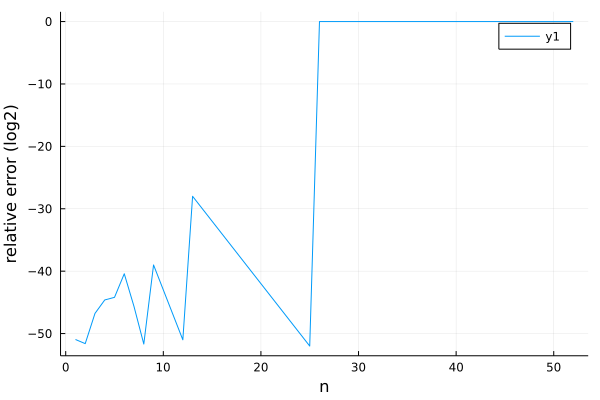

In [29]:
using Plots
S=precision(Float64)-1;
relative_error=zeros(S)
for n=1:S
    h=2.0^(-n)
    exact=1-sqrt(1+BigFloat(h)^2)
    numerical=1-sqrt(1+h^2)
    relative_error[n]=-abs(numerical-exact)/exact
end
plot(1:S,log2.(relative_error), xlabel="n", ylabel="relative error (log2)")

From this plot we can clearly identify the 3 phases:
1. When $n$ is very small, the relative error grows smoothly with $n$;
2. When $n$ is neither too large nor too small, the relative error has jumps at around $S/2=26$, $(S-3)/4=12.25$, $(S-4)/6=8$. In each stage, the slope is as predicted. For example, the first stage from $S/2$ to $(S-3)/4$ has relative error of $\frac{1}{4}h^2$, hence the slope is -2 between 13 and 25.
3. When $n\ge S/2$, the relative error is 100%;

The transition point between phase 1 and 2 is at the stage for $O(h^8)$ of relative error from phase 2 which meets $\frac{\epsilon_m}{h^2}$ from phase 1.